# Checkpoint 24.6 | Supervised learning: random forest models

# Assignment

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club (2015) to predict the state of a loan given some information about it. You can download the dataset [here](https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1).

Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-up" data-toc-modified-id="Set-up-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Set up</a></span></li><li><span><a href="#Loading-the-dataset" data-toc-modified-id="Loading-the-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading the dataset</a></span></li><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data cleaning</a></span></li><li><span><a href="#Creating-dummies-and-splitting-data" data-toc-modified-id="Creating-dummies-and-splitting-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Creating dummies and splitting data</a></span></li><li><span><a href="#Establish-baseline-RFM-scores" data-toc-modified-id="Establish-baseline-RFM-scores-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Establish baseline RFM scores</a></span></li><li><span><a href="#Removing-features" data-toc-modified-id="Removing-features-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Removing features</a></span></li></ul></div>

## Set up

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

## Loading the dataset

In [63]:
raw = pd.read_csv('/Users/chanvarma/Box/datasets-chanvarma/thinkful/lending-club-data/LoanStats3d.csv', 
                 skipinitialspace=True, header=1)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [64]:
data = raw.copy()

In [65]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


## Data cleaning

Since pd.get_dummies() is a very memory intensive function, we must first clean our categorical data and and understanding if some categorical variables are essentially unique at the scale of the df's length.

In [66]:
categorical = data.select_dtypes(include=['object'])
unique_counts = {}

for i in categorical:
    unique_counts[i] = categorical[i].nunique()
    
unique_counts = {k: v for k, v in sorted(unique_counts.items(), key=lambda item: item[1], reverse = True)}
unique_counts

{'id': 421097,
 'url': 421095,
 'emp_title': 120812,
 'revol_util': 1211,
 'zip_code': 914,
 'earliest_cr_line': 668,
 'int_rate': 110,
 'addr_state': 49,
 'sub_grade': 35,
 'desc': 34,
 'title': 27,
 'last_credit_pull_d': 26,
 'last_pymnt_d': 25,
 'purpose': 14,
 'issue_d': 12,
 'emp_length': 11,
 'grade': 7,
 'loan_status': 7,
 'home_ownership': 4,
 'next_pymnt_d': 4,
 'verification_status': 3,
 'verification_status_joint': 3,
 'term': 2,
 'initial_list_status': 2,
 'application_type': 2,
 'pymnt_plan': 1}

In [67]:
data[['id', 'emp_title', 'revol_util', 'url', 'earliest_cr_line', 'int_rate', 'addr_state', 'sub_grade']].head()

,id,emp_title,revol_util,url,earliest_cr_line,int_rate,addr_state,sub_grade
0,68009401,Bookkeeper/Accounting,29.6%,https://lendingclub.com/browse/loanDetail.acti...,Jun-1991,14.85%,SC,C5
1,68354783,tech,59.4%,https://lendingclub.com/browse/loanDetail.acti...,Jun-1996,7.49%,SC,A4
2,68466916,Sales Manager,54.3%,https://lendingclub.com/browse/loanDetail.acti...,Dec-2001,7.49%,VA,A4
3,68466961,Senior Manager,64.5%,https://lendingclub.com/browse/loanDetail.acti...,May-1984,6.49%,NC,A2
4,68495092,Program Coordinator,46%,https://lendingclub.com/browse/loanDetail.acti...,Mar-2005,19.89%,IN,E3


In [68]:
data[['desc', 'title', 'last_credit_pull_d', 'last_pymnt_d', 'purpose']].head()

,desc,title,last_credit_pull_d,last_pymnt_d,purpose
0,NaN,Credit card refinancing,Jan-2017,Jan-2017,credit_card
1,NaN,Credit card refinancing,Jan-2017,Jan-2017,credit_card
2,NaN,Debt consolidation,Jan-2017,Sep-2016,debt_consolidation
3,NaN,Debt consolidation,Jan-2017,Jan-2017,debt_consolidation
4,NaN,Debt consolidation,Jun-2016,May-2016,debt_consolidation


In [69]:
data.isna().sum()/data.isna().count()

id                            0.000000
member_id                     0.000005
loan_amnt                     0.000005
funded_amnt                   0.000005
funded_amnt_inv               0.000005
                                ...   
tax_liens                     0.000005
tot_hi_cred_lim               0.000005
total_bal_ex_mort             0.000005
total_bc_limit                0.000005
total_il_high_credit_limit    0.000005
Length: 111, dtype: float64

Based on this: 
* we can drop the `url`, `desc`, `revol_util`, `zipcode`, `earliest_cr_line` and `emp_title` columnns because they are extremely unique
* convert `id`, `int_rate` to numeric variables
* drop all NaN rows
* convert `last_credit_pull_d` and `last_pymnt_d` to quarters

In [70]:
data.shape

(421097, 111)

In [71]:
data.drop(columns = ['url', 'desc', 'emp_title', 'revol_util', 'zip_code', 'earliest_cr_line'], inplace = True)

In [72]:
data['id'] = pd.to_numeric(data['id'], errors='coerce')
data['int_rate'] = pd.to_numeric(data['int_rate'].str.strip('%'), errors='coerce')

In [73]:
def date_to_quarter(date_row):
    
    date_row = str(date_row).lower()
    
    if ('jan' in date_row or 'feb' in date_row or 'mar' in date_row):
        quarter = 'Q1'
    elif ('apr' in date_row or 'jun' in date_row or 'may' in date_row):
        quarter = 'Q2'
    elif ('aug' in date_row or 'sep' in date_row or 'jul' in date_row):
        quarter = 'Q3'
    elif ('oct' in date_row or 'nov' in date_row or 'dec' in date_row):
        quarter = 'Q4'
    else:
        return None
             
    year = date_row[-4:]
    
    return quarter + ' ' + year


data['last_pymnt_d_quartered'] = data['last_pymnt_d'].apply(date_to_quarter)
data['last_credit_pull_d_quartered'] = data['last_credit_pull_d'].apply(date_to_quarter)

data.drop(columns = ['last_pymnt_d', 'last_credit_pull_d'], inplace = True)

In [74]:
data['last_pymnt_d_quartered'].value_counts()

Q1 2017    261646
Q4 2016     59800
Q3 2016     26036
Q2 2016     22573
Q1 2016     21044
Q4 2015     14735
Q3 2015      9475
Q2 2015      4411
Q1 2015      1081
Name: last_pymnt_d_quartered, dtype: int64

In [75]:
data.dropna(how = 'all', inplace = True)
data.shape

(421095, 105)

As intended.

## Creating dummies and splitting data

In [76]:
safe = data.copy()

In [61]:
X = data.drop('loan_status', 1)
Y = data['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis = 1)

X.shape, Y.shape

((421095, 253), (421095,))

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 13, test_size = .25)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((315821, 253), (105274, 253), (315821,), (105274,))

## Establish baseline RFM scores

In [17]:
models = {}

In [29]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from math import sqrt

rfc = ensemble.RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [30]:
rfc.score(X_train, Y_train)

0.9999873345977627

In [31]:
rfc.score(X_test, Y_test)

0.9685867355662366

...I'm really unsure how to proceed from here! My model seems to be extremely accurate!

## Removing features

We start by looking at the correlation between the features to highly correlated ones. We can start by using PCA.

In [98]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_ft = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)
X_ft.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,last_credit_pull_d_quartered_Q1 2015,last_credit_pull_d_quartered_Q1 2016,last_credit_pull_d_quartered_Q1 2017,last_credit_pull_d_quartered_Q2 2015,last_credit_pull_d_quartered_Q2 2016,last_credit_pull_d_quartered_Q3 2015,last_credit_pull_d_quartered_Q3 2016,last_credit_pull_d_quartered_Q4 2014,last_credit_pull_d_quartered_Q4 2015,last_credit_pull_d_quartered_Q4 2016
0,1.485786,1.507108,0.088634,0.088634,0.089385,0.520931,-0.255135,-0.391692,0.594963,-0.374473,...,-0.02679,-0.131417,0.433710,-0.049997,-0.144656,-0.07362,-0.156237,-0.003446,-0.094715,-0.293876
1,1.522236,1.544253,-0.658042,-0.658042,-0.657587,-1.183385,-0.585173,-0.229420,0.138019,-0.374473,...,-0.02679,-0.131417,0.433710,-0.049997,-0.144656,-0.07362,-0.156237,-0.003446,-0.094715,-0.293876
2,1.534070,1.555326,1.138648,1.138648,1.139814,-1.183385,1.370997,0.433191,0.290334,-0.374473,...,-0.02679,-0.131417,0.433710,-0.049997,-0.144656,-0.07362,-0.156237,-0.003446,-0.094715,-0.293876
3,1.534075,1.555330,1.488653,1.488653,1.489957,-1.414950,1.699769,0.203305,0.102281,-0.374473,...,-0.02679,-0.131417,0.433710,-0.049997,-0.144656,-0.07362,-0.156237,-0.003446,-0.094715,-0.293876
4,1.537044,1.558100,-0.768877,-0.768877,-0.768466,1.688017,-0.493648,-0.297034,0.267785,-0.374473,...,-0.02679,-0.131417,-2.305689,-0.049997,6.912935,-0.07362,-0.156237,-0.003446,-0.094715,-0.293876


In [105]:
pca = PCA(n_components=20)
pca.fit(X_ft) # do the math
pca_data = pca.transform(X_ft) # get PCA coordinates for scaled_data

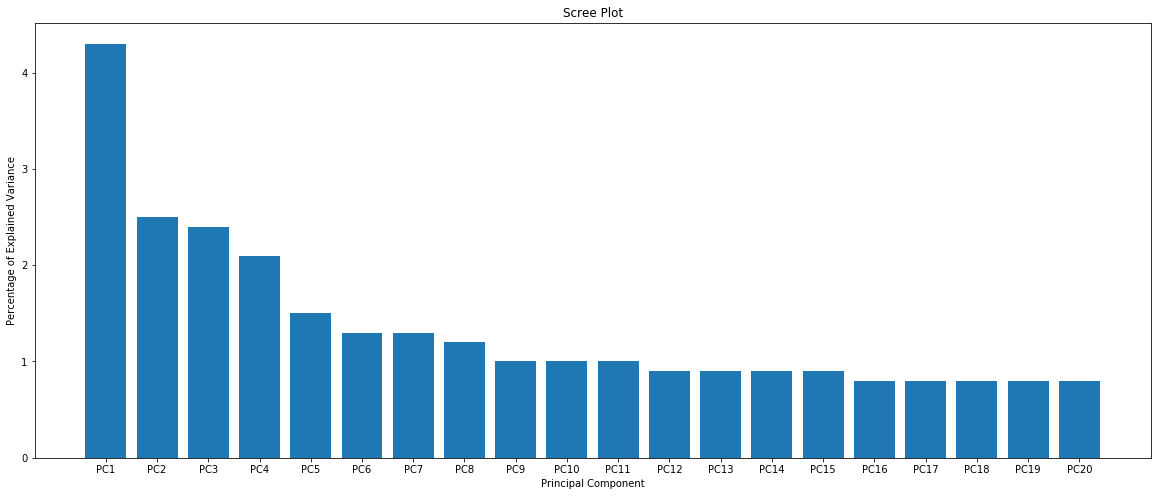

In [106]:
#########################
#
# Draw a scree plot and a PCA plot
#
#########################
 
#The following code constructs the Scree plot
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.figure(figsize=(20, 8))
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()